## Naive approach

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flwr as fl
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams["figure.figsize"] = (25,15)

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [4]:
path="/Users/daniel.bustillo/Documents/thesis"

os.chdir(path)

In [5]:
homes= pd.read_csv("homes.csv", infer_datetime_format=True, index_col=0)

In [6]:
energy= homes['total_a']
energy= energy.dropna()
energy = energy.values
energy= energy.reshape(len(energy),1)

In [7]:
# Data partitining 
train_size  = int(len(energy) * 0.80)
test_size   = len(energy) - train_size
train, test = energy[:train_size], energy[train_size:]

In [8]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [9]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [14]:
timesteps = 1 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(14090, 1, 1)

In [15]:
model = Sequential()
model.add(LSTM(8))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [16]:
# Training
history= model.fit(X_train, y_train, epochs=110, batch_size=24, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Epoch 1/110
588/588 - 3s - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0081 - val_mse: 0.0081 - 3s/epoch - 6ms/step
Epoch 2/110
588/588 - 1s - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0071 - val_mse: 0.0071 - 1s/epoch - 2ms/step
Epoch 3/110
588/588 - 1s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 4/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 5/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0070 - val_mse: 0.0070 - 1s/epoch - 2ms/step
Epoch 6/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0069 - val_mse: 0.0069 - 992ms/epoch - 2ms/step
Epoch 7/110
588/588 - 1s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0069 - val_mse: 0.0069 - 1s/epoch - 2ms/step
Epoch 8/110
588/588 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0069 - val_mse: 0.0069 - 1s/epoch - 2ms/step
Epoch 9/110
588/588 - 1s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0068 - val_mse: 0.0068 - 

In [17]:
pred_train ={}
pred_test = {}

pred_train["true"] = scaler.inverse_transform(y_train).flatten()  # store as 1d array
pred_test["true"]  = scaler.inverse_transform(y_test).flatten() 

pred_train["simple_lstm"] = scaler.inverse_transform(
                              model.predict(X_train,verbose=0)).flatten()

pred_test['simple_lstm'] = scaler.inverse_transform(model.predict(X_test)).flatten()

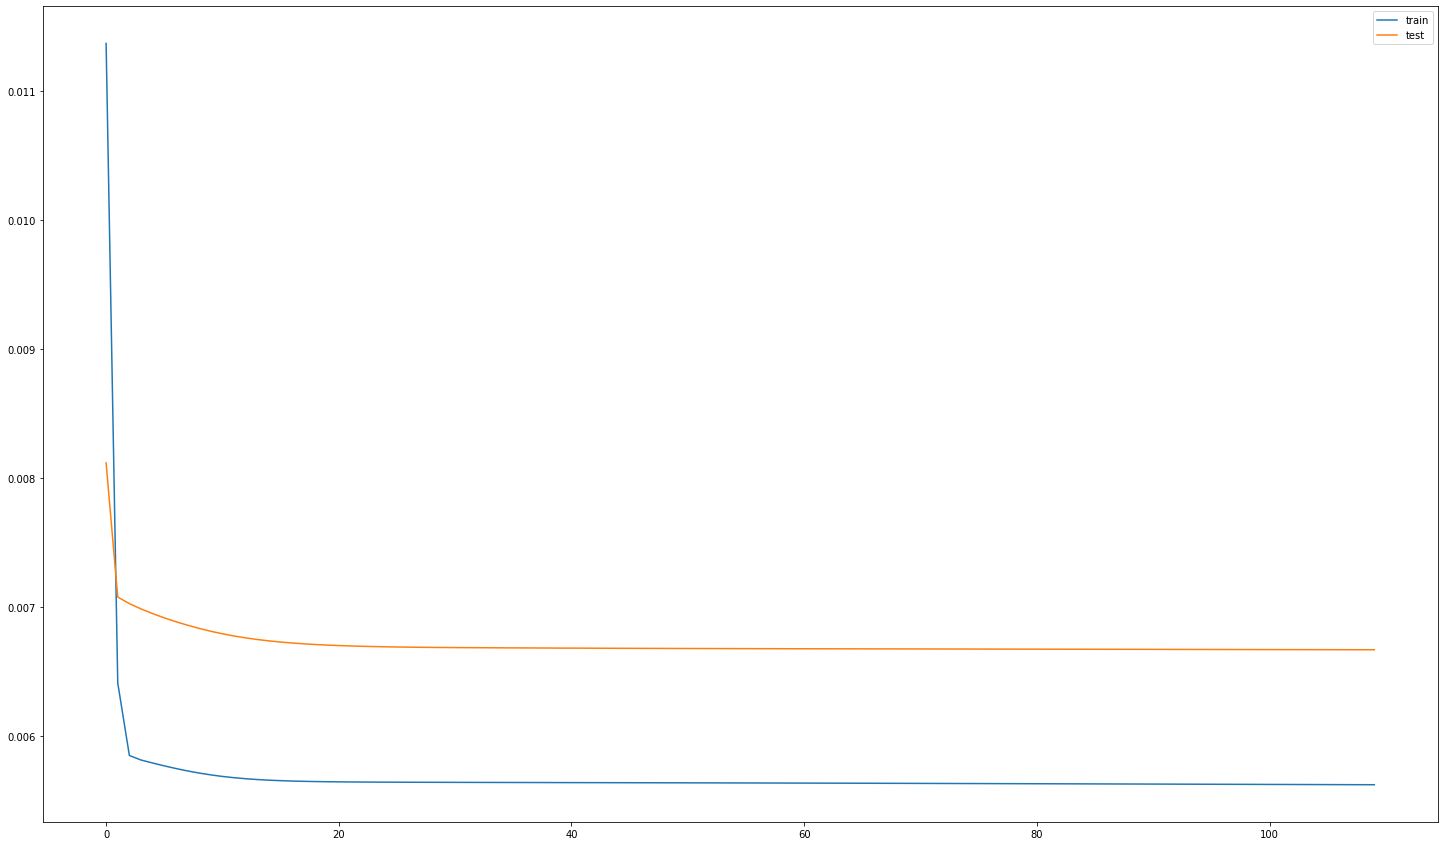

In [18]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

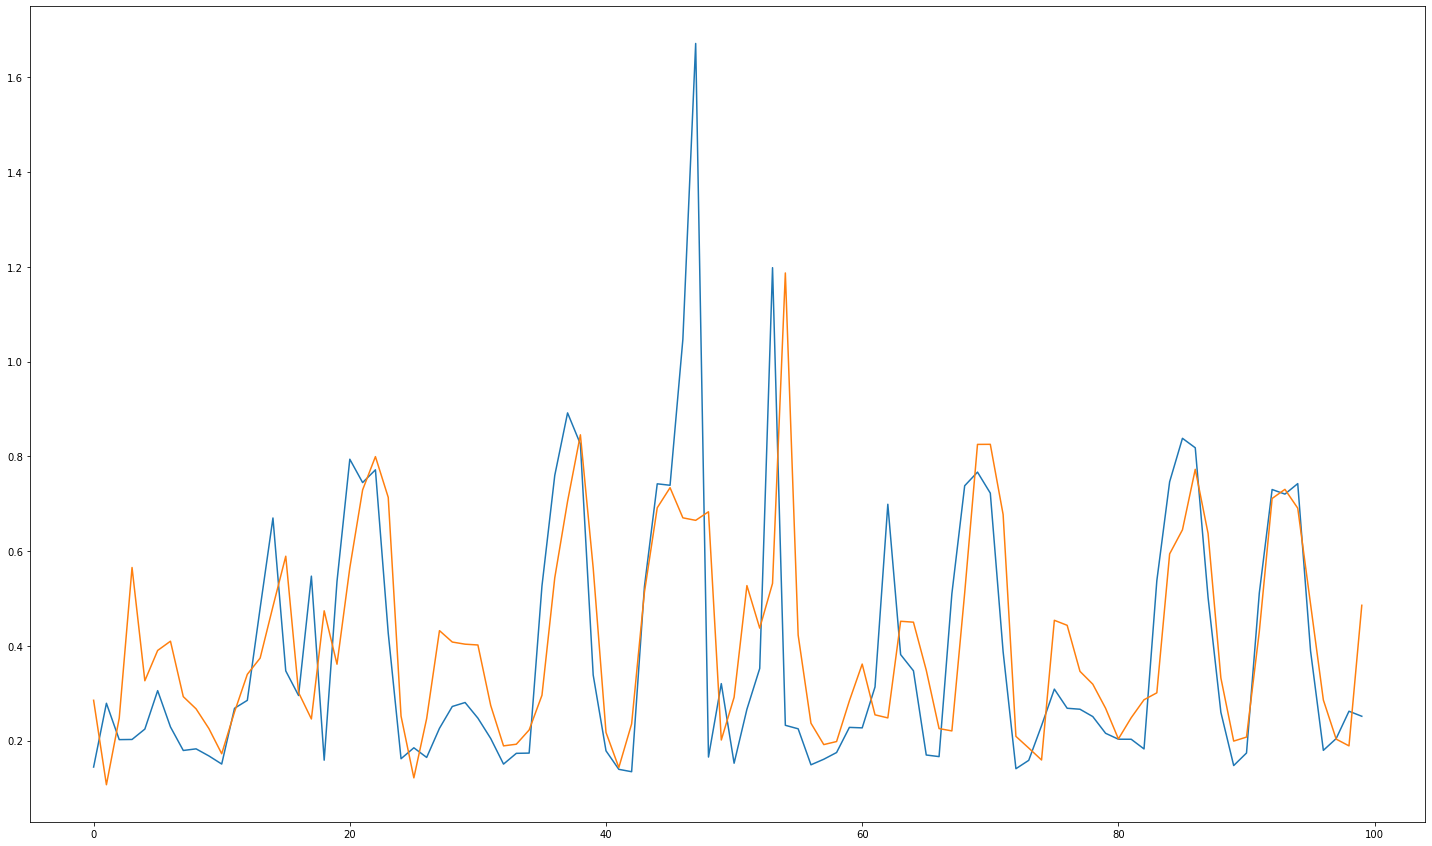

In [181]:
# plt.plot(pred_train['true'])
# plt.plot(pred_train['simple_lstm'])

plt.plot(pred_test['true'][0:100])
plt.plot(pred_test['simple_lstm'][0:100])
plt.show()


In [182]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [183]:
rmse_train={}
rmse_test={}

In [184]:
rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_test["naive"]  = rmse(pred_test["true"],  pred_test["simple_lstm"])

In [188]:
rmse_test

{'naive': 0.2583147014240696}

In [315]:
def prepare_task(home, prop=0.8):

    home= home.dropna()
    home = home.values
    home= home.reshape(len(home),1)
    return home

    # # Data partitining 
    # train_size  = int(len(home) * prop)
    # test_size   = len(home) - train_size
    # train, test = energy[:train_size], energy[train_size:]



    # # The LSTM input layer must be 3D
    # # Create the dataset with rolling window for the training set and test set
    # X_train, y_train  = create_dataset(train, timesteps)  # lookback
    # X_test, y_test    = create_dataset(test, timesteps)

In [316]:
energy1= homes['total_a']
energy1= prepare_task(energy1)

In [317]:
train, test = train_test_split(energy1, train_size=0.8, shuffle=False)

In [189]:
def scale(train, test):

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    return train, test

In [190]:
train, test = scale(train, test)

In [191]:
timesteps= 13
# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)

In [192]:
stateless_multilayer = Sequential()
stateless_multilayer.add(LSTM(7, return_sequences=True))
stateless_multilayer.add(Dropout(0.2))  # you can also add dropout layers if you like
stateless_multilayer.add(LSTM(7, return_sequences=False))
stateless_multilayer.add(Dropout(0.2))
stateless_multilayer.add(Dense(1))
stateless_multilayer.compile(loss = 'mean_squared_error', optimizer = "adam", metrics=['mse'])

In [193]:
history1=stateless_multilayer.fit(X_train, y_train, batch_size=24,epochs=50, validation_split=0.3 )

Epoch 1/50
411/411 [==============================] - 8s 12ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0089 - val_mse: 0.0089
Epoch 2/50
411/411 [==============================] - 5s 11ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 3/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0078 - val_mse: 0.0078
Epoch 4/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/50
411/411 [==============================] - 4s 11ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 7/50
411/411 [==============================] - 4s 10ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/50
411/411 [==============================] - 5s 11ms/step - 

In [194]:
pred_train["multilayer"] = scaler.inverse_transform(
                              stateless_multilayer.predict(X_train,verbose=0)).flatten()

pred_test['multilayer'] = scaler.inverse_transform(stateless_multilayer.predict(X_test)).flatten()

In [204]:
pred_test = pd.DataFrame(pred_test)

<AxesSubplot:>

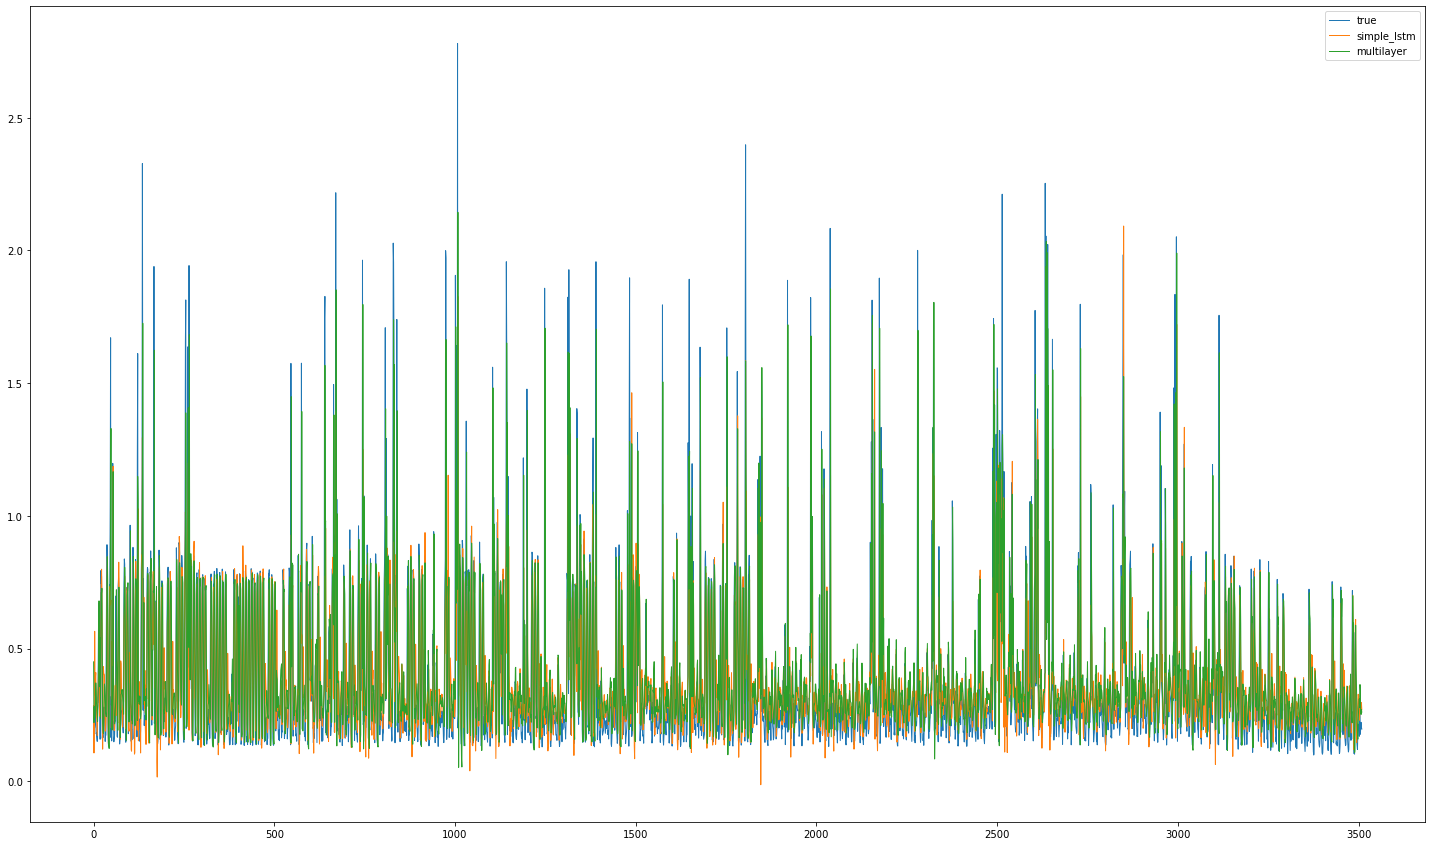

In [202]:
pd.DataFrame(pred_test).plot(lw=1)

In [196]:
rmse_train["stateless_multilayer"] = rmse(pred_train["true"], pred_train["multilayer"])
rmse_test["stateless_multilayer"] = rmse(pred_test["true"], pred_test["multilayer"])

In [197]:
rmse_train

{'naive': 0.2290306977116612, 'stateless_multilayer': 0.23954870727576888}

In [198]:
rmse_test

{'naive': 0.2583147014240696, 'stateless_multilayer': 0.28528711404753293}

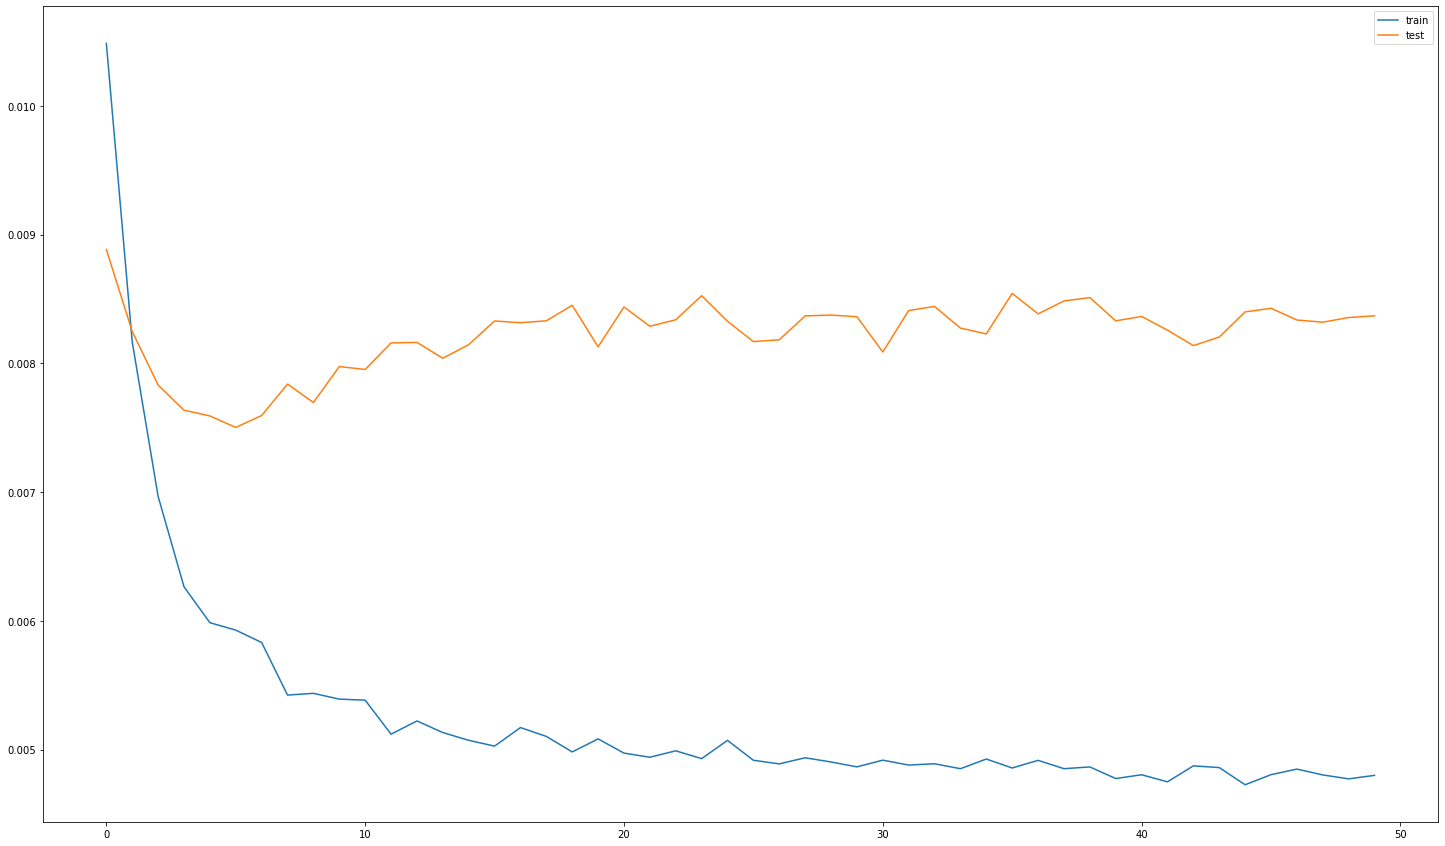

In [199]:
# plot history
plt.plot(history1.history['loss'], label='train')
plt.plot(history1.history['val_loss'], label='test')
plt.legend()
plt.show()

### Multivariate Time Series forecasting with LSTMS

The approach for multivariate Time series forecasting consists of using a lagged version of all features to predict the present value of the target variable

In [22]:
example = homes

In [23]:
values = example.values
values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = [],[]
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('home_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('home_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('home_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1, dropnan=False)

In [227]:
itercols = [col for col in reframed.columns if '(t)' in col]
cols1 = [col for col in reframed.columns if '(t-' in col]

In [424]:
home_b = reframed.iloc[:,[1,2,4,8]]

<AxesSubplot:>

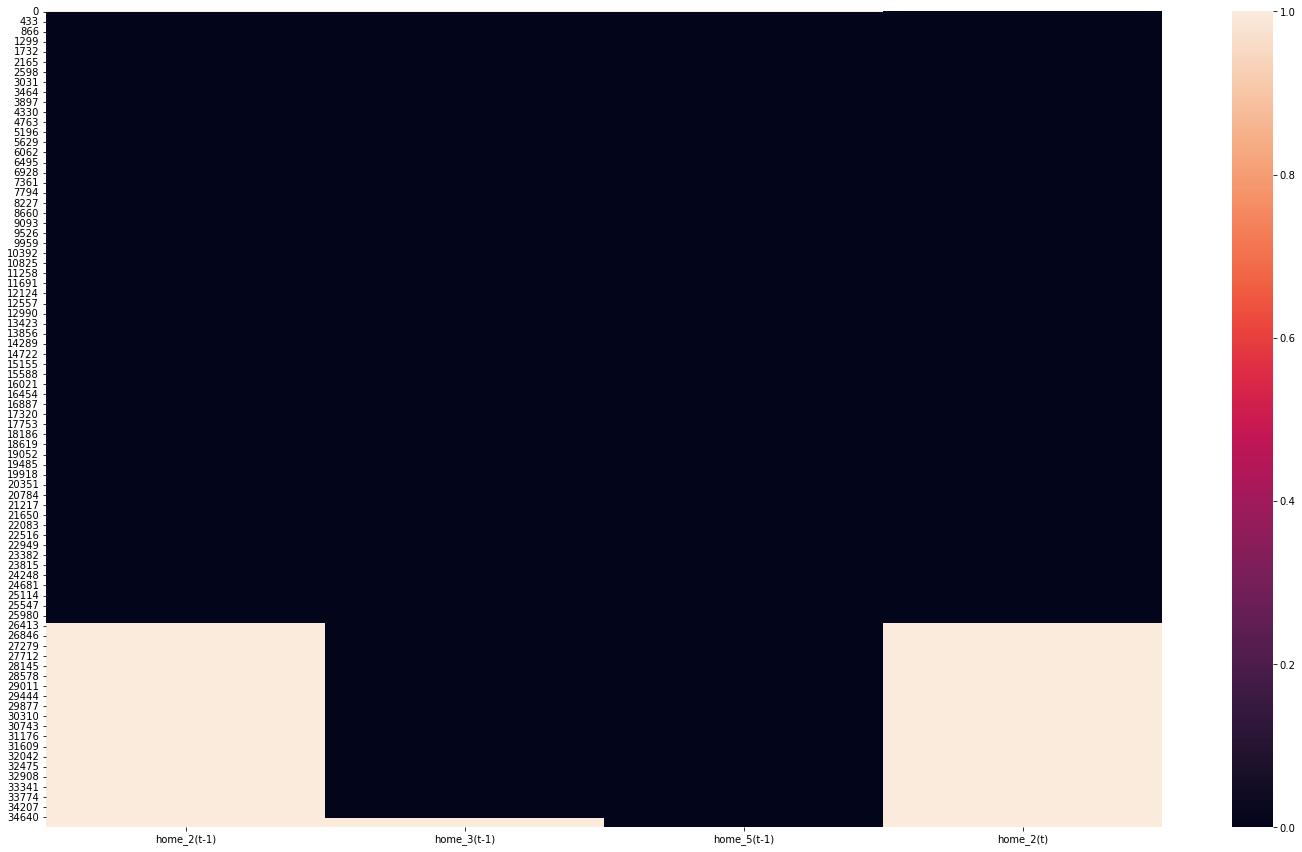

In [388]:
import seaborn as sns
sns.heatmap(home_b.isna())

In [425]:
home_b= home_b.dropna()

In [426]:
# split into train and test sets
values = home_b.values

train, test = train_test_split(values, train_size=0.9, shuffle=False)


In [427]:
# Scaling the data to the interval [0,1]

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [428]:
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test =test[:, :-1], test[:,-1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(23651, 1, 3) (23651,) (2628, 1, 3) (2628,)


In [429]:
# design network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [430]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 256)               266240    
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 266,497
Trainable params: 266,497
Non-trainable params: 0
_________________________________________________________________


In [431]:
# fit network
history2 = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2, shuffle=False)


Epoch 1/50
370/370 - 3s - loss: 0.0421 - 3s/epoch - 8ms/step
Epoch 2/50
370/370 - 1s - loss: 0.0335 - 1s/epoch - 4ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 5ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0335 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 7/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 8/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 9/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 10/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 5ms/step
Epoch 11/50
370/370 - 2s - loss: 0.0333 - 2s/epoch - 4ms/step
Epoch 12/50
370/370 - 2s - loss: 0.0334 - 2s/epoch - 4ms/step
Epoch 13/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 14/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 15/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 16/50
370/370 - 1s - loss: 0.0333 - 1s/epoch - 4ms/step
Epoch 17/50
370/3

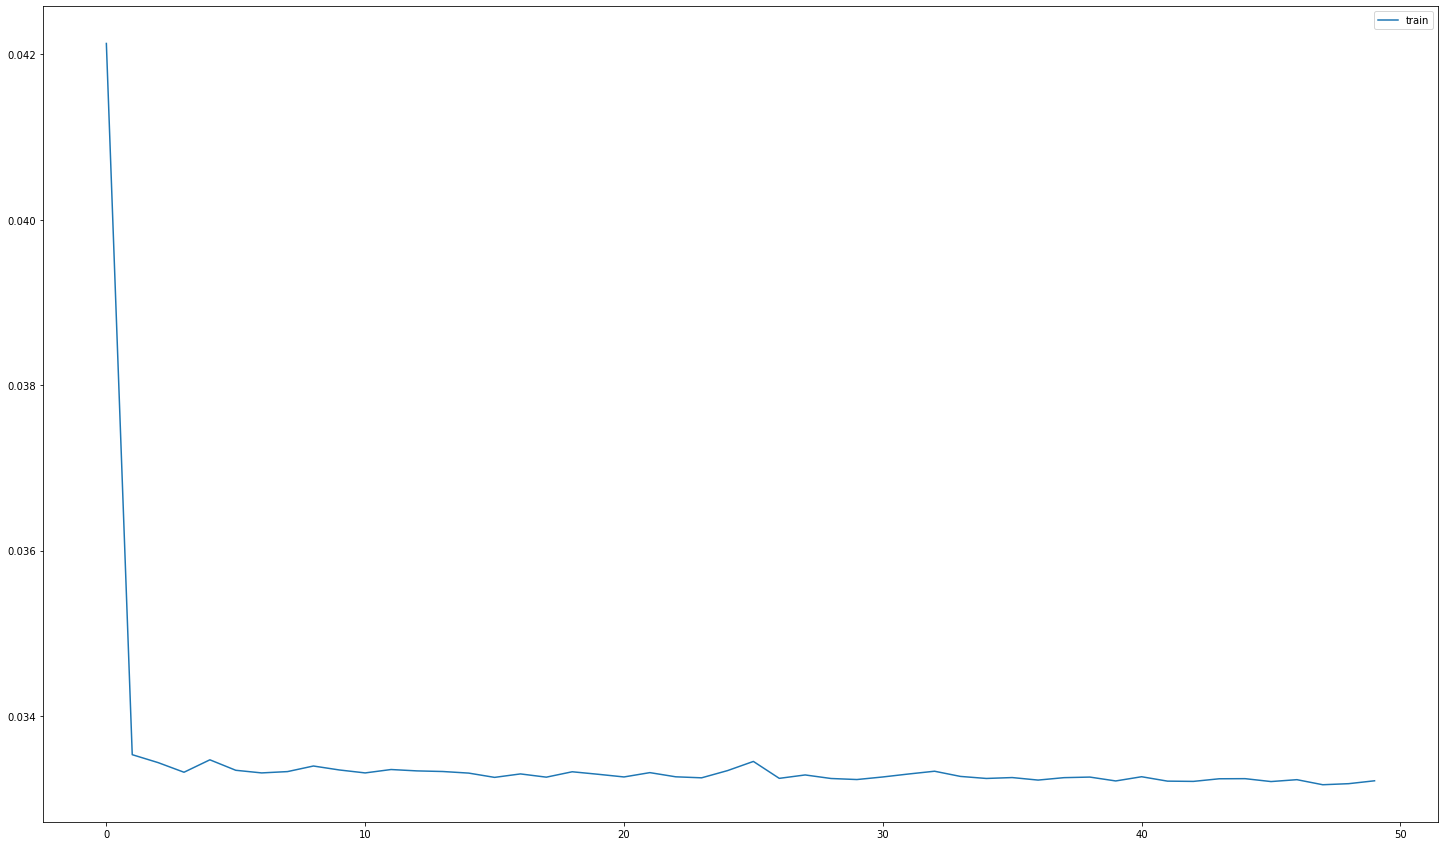

In [432]:
# plot history
plt.plot(history2.history['loss'], label='train')
#plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

In [434]:
#Predict model
yhat= model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = np.concatenate((X_test, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,-1]
#Invert scaling for actual 
y_test = y_test.reshape(len(y_test),1)
inv_y= np.concatenate((X_test, y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,-1]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))

print("Test RMSE %.3f" % rmse)

In [449]:
pred_b_train= {}
pred_b_test= {}

pred_b_test['true'] = inv_y
pred_b_test['multi'] = inv_yhat

In [453]:
rmse_b_train = {}
rmse_b_test = {}

In [163]:
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_score):
    error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
    return error

In [457]:
# rmse_train["naive"] = rmse(pred_train["true"], pred_train["simple_lstm"])
rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

In [458]:
rmse_b_test

{'naive': 0.6942053}

In [461]:
pred_b_test = pd.DataFrame(pred_b_test)

In [466]:
pred_b_test['error'] = pred_b_test['true']-pred_b_test['multi']

In [465]:
home_b.iloc[23651:,:]

,home_2(t-1),home_3(t-1),home_5(t-1),home_2(t)
23652,1.629508,0.665316,1.526671,1.427628
23653,1.427628,0.480934,3.545602,1.427628
23654,1.427628,0.480934,3.545602,1.563216
23655,1.563216,1.355315,5.656806,1.563216
23656,1.563216,1.355315,5.656806,1.447643
...,...,...,...,...
26275,1.628335,1.658045,11.014453,1.628335
26276,1.628335,1.658045,11.014453,1.736318
26277,1.736318,1.516558,6.889673,1.736318
26278,1.736318,1.516558,6.889673,1.537199


In [610]:
def train_model(df, train_size = 0.9, neurons = 256, epochs=50, batch_size=64):
    '''function that takes a cleaned version of the modified dataframe, transforms the data into 
    [Samples, timesteps, features] , splits it into training and testing data, and trains a model on the 
    fitted data to then predict the test data and calculate the root mean square'''
    #Drop nan values
    df= df.dropna()
    # train, test split
    # split into train and test sets
    values = df.values
    train, test = train_test_split(values, train_size=train_size, shuffle=False)

    # Scaling the data to the interval [0,1]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler = scaler.fit(train)

    train = scaler.transform(train)
    test  = scaler.transform(test)
    
    
    X_train, y_train = train[:, :-1], train[:, -1]
    X_test, y_test =test[:, :-1], test[:,-1]
    
    # reshape input to be 3D [samples, timesteps, features]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # design network
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam', metrics=["mean_absolute_percentage_error", "mean_absolute_error"])


    # fit network
    history2 = model.fit(X_train, y_train,epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    # plot history
    plt.plot(history2.history['loss'], label='train')
    #plt.plot(history2.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    #Predict model
    yhat= model.predict(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
    inv_yhat = np.concatenate((X_test, yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat=inv_yhat[:,-1]
    #Invert scaling for actual 
    y_test = y_test.reshape(len(y_test),1)
    inv_y= np.concatenate((X_test, y_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)

    inv_y = inv_y[:,-1]

    def rmse(y_true, y_score):
        error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
        return error
   
    #pred_b_train= {}
    pred_b_test= {}

    pred_b_test['true'] = inv_y
    pred_b_test['multi'] = inv_yhat

    rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

    pred_b_test = pd.DataFrame(pred_b_test)
    print(rmse_b_test)

    pred_b_test.plot()

    return pred_b_test

    
    

    

    
    

In [472]:
reframed

,home_1(t-1),home_2(t-1),home_3(t-1),home_4(t-1),home_5(t-1),home_6(t-1),home_7(t-1),home_1(t),home_2(t),home_3(t),home_4(t),home_5(t),home_6(t),home_7(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN
1,NaN,1.676843,2.689820,NaN,2.060571,NaN,NaN,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN
2,NaN,2.167156,1.518391,NaN,1.212912,NaN,NaN,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN
3,NaN,1.102414,1.963862,NaN,1.342836,NaN,NaN,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN
4,NaN,1.910317,2.223022,NaN,1.549448,NaN,NaN,NaN,1.479763,1.855156,NaN,2.604672,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,0.263403,NaN,NaN,7.307169,1.542869,0.184146,NaN,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN
35060,0.177386,NaN,NaN,8.789098,1.479447,0.669979,NaN,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN
35061,0.199725,NaN,NaN,8.362465,1.439440,0.234510,NaN,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN
35062,0.222266,NaN,NaN,6.216546,1.410874,0.278918,NaN,0.203904,NaN,NaN,6.726995,0.975436,0.106219,NaN


In [484]:
home_c = reframed.iloc[:,[1,2,4,9]]
home_d = reframed.iloc[:,[0,2,3,4,5,10]]
home_f = reframed.iloc[:,[1,2,4,11]]
home_g= reframed.iloc[:,[0,2,3,4,5,6,12]]

(23652, 1, 3) (23652,) (2628, 1, 3) (2628,)
Epoch 1/50
370/370 - 3s - loss: 0.0383 - mean_absolute_percentage_error: 14561.4609 - mean_absolute_error: 0.0383 - 3s/epoch - 9ms/step
Epoch 2/50
370/370 - 2s - loss: 0.0266 - mean_absolute_percentage_error: 9448.8555 - mean_absolute_error: 0.0266 - 2s/epoch - 4ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0265 - mean_absolute_percentage_error: 9693.5488 - mean_absolute_error: 0.0265 - 2s/epoch - 4ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0265 - mean_absolute_percentage_error: 9521.2646 - mean_absolute_error: 0.0265 - 2s/epoch - 4ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9563.7656 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9351.3184 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0264 - mean_absolute_percentage_error: 9479.2246 - mean_absolute_error: 0.0264 - 2s/epoch - 4ms/step
Epoch 8/50

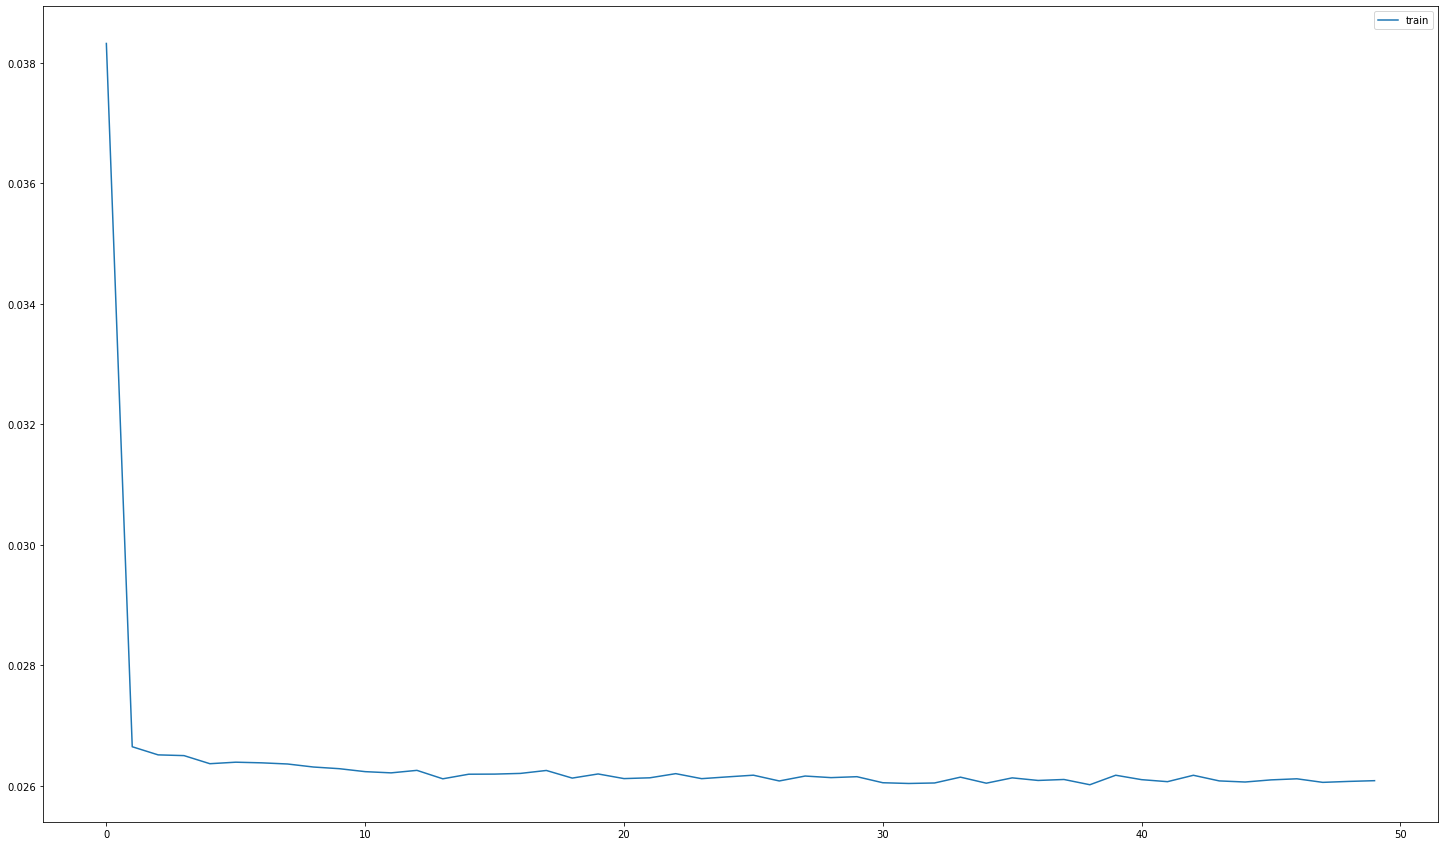

{'naive': 0.45561862}


,true,multi
0,0.480934,0.481629
1,1.355315,0.481629
2,1.355315,1.345887
3,2.060117,1.345887
4,2.060117,2.047921
...,...,...
2623,1.516558,1.647298
2624,1.516558,1.505648
2625,1.883781,1.505648
2626,1.883781,1.871258


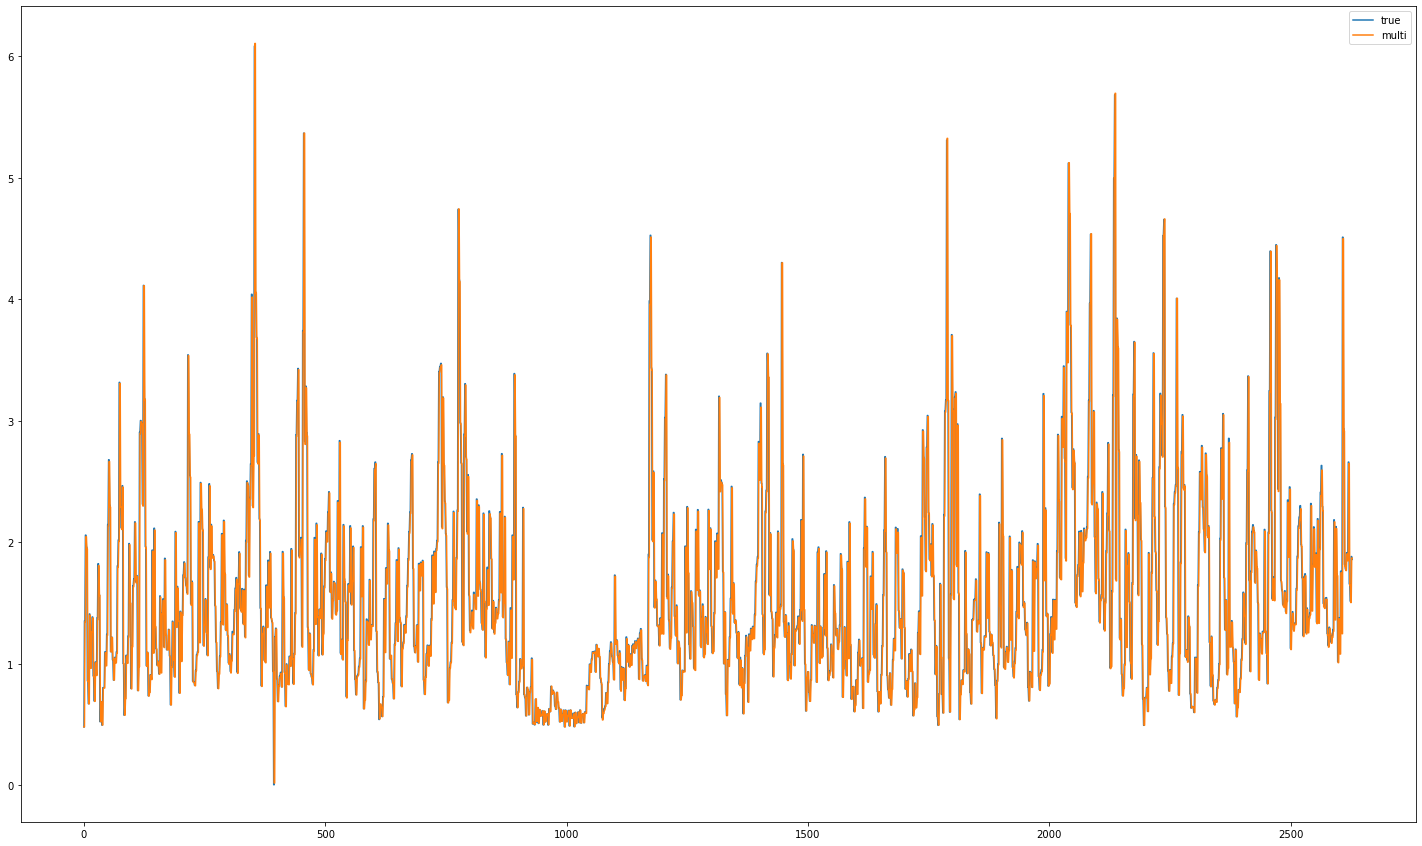

In [613]:
train_model(home_c)

(12654, 1, 5) (12654,) (1407, 1, 5) (1407,)
Epoch 1/50
198/198 - 2s - loss: 0.0724 - mean_absolute_percentage_error: 4171.4697 - mean_absolute_error: 0.0724 - 2s/epoch - 11ms/step
Epoch 2/50
198/198 - 1s - loss: 0.0478 - mean_absolute_percentage_error: 2057.9595 - mean_absolute_error: 0.0478 - 821ms/epoch - 4ms/step
Epoch 3/50
198/198 - 1s - loss: 0.0477 - mean_absolute_percentage_error: 2089.0977 - mean_absolute_error: 0.0477 - 851ms/epoch - 4ms/step
Epoch 4/50
198/198 - 1s - loss: 0.0475 - mean_absolute_percentage_error: 1977.7385 - mean_absolute_error: 0.0475 - 851ms/epoch - 4ms/step
Epoch 5/50
198/198 - 1s - loss: 0.0474 - mean_absolute_percentage_error: 1962.5457 - mean_absolute_error: 0.0474 - 831ms/epoch - 4ms/step
Epoch 6/50
198/198 - 1s - loss: 0.0473 - mean_absolute_percentage_error: 1897.3329 - mean_absolute_error: 0.0473 - 847ms/epoch - 4ms/step
Epoch 7/50
198/198 - 1s - loss: 0.0473 - mean_absolute_percentage_error: 2016.4114 - mean_absolute_error: 0.0473 - 830ms/epoch - 4

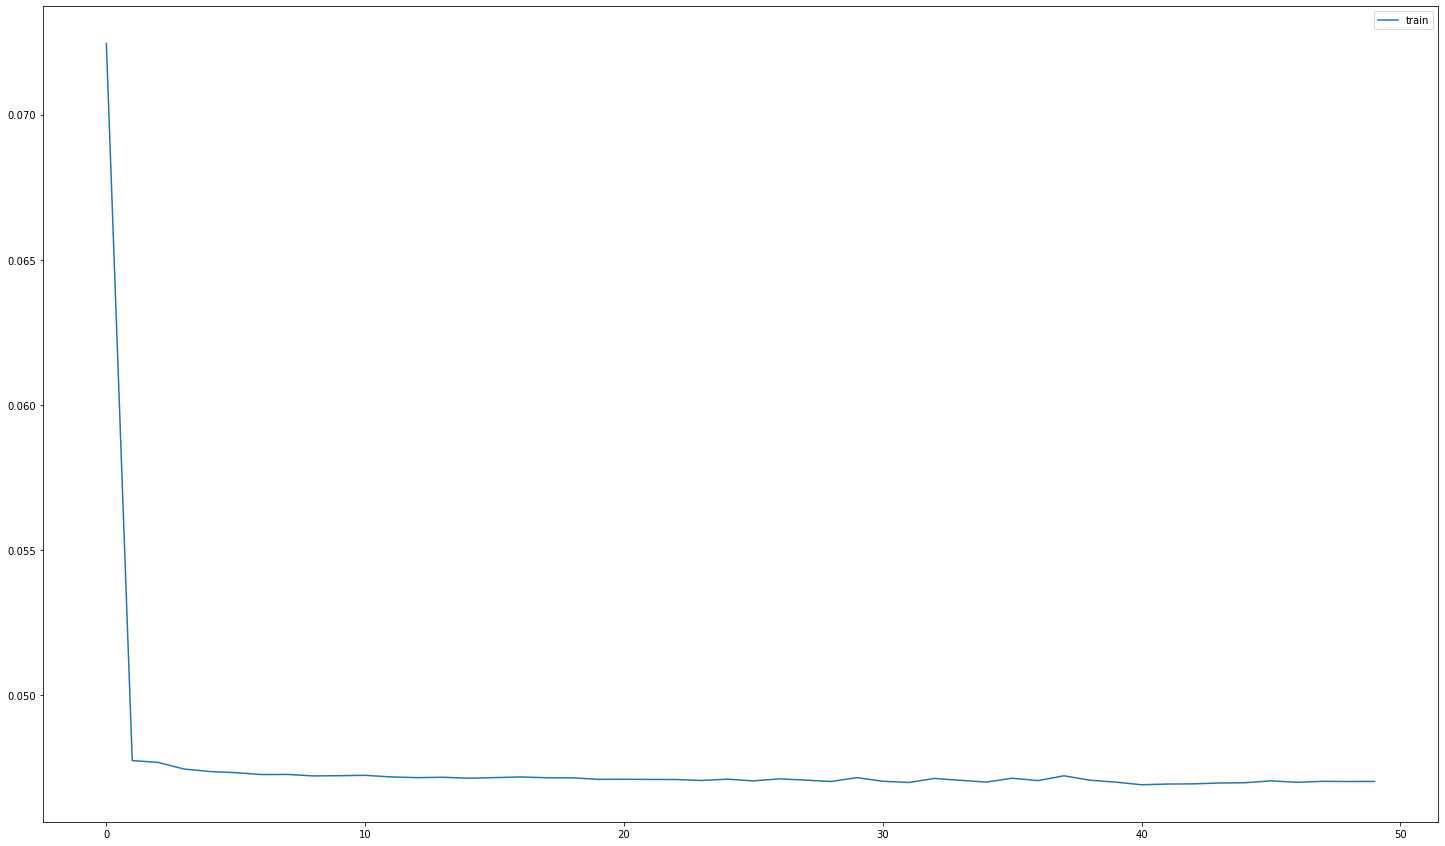

{'naive': 2.6869109}


,true,multi
0,1.645347,0.524019
1,3.620700,1.574680
2,4.240813,3.370787
3,4.364341,3.848875
4,4.238812,4.019647
...,...,...
1402,5.718519,5.118991
1403,4.957617,5.041614
1404,4.777308,4.331275
1405,3.900701,4.589159


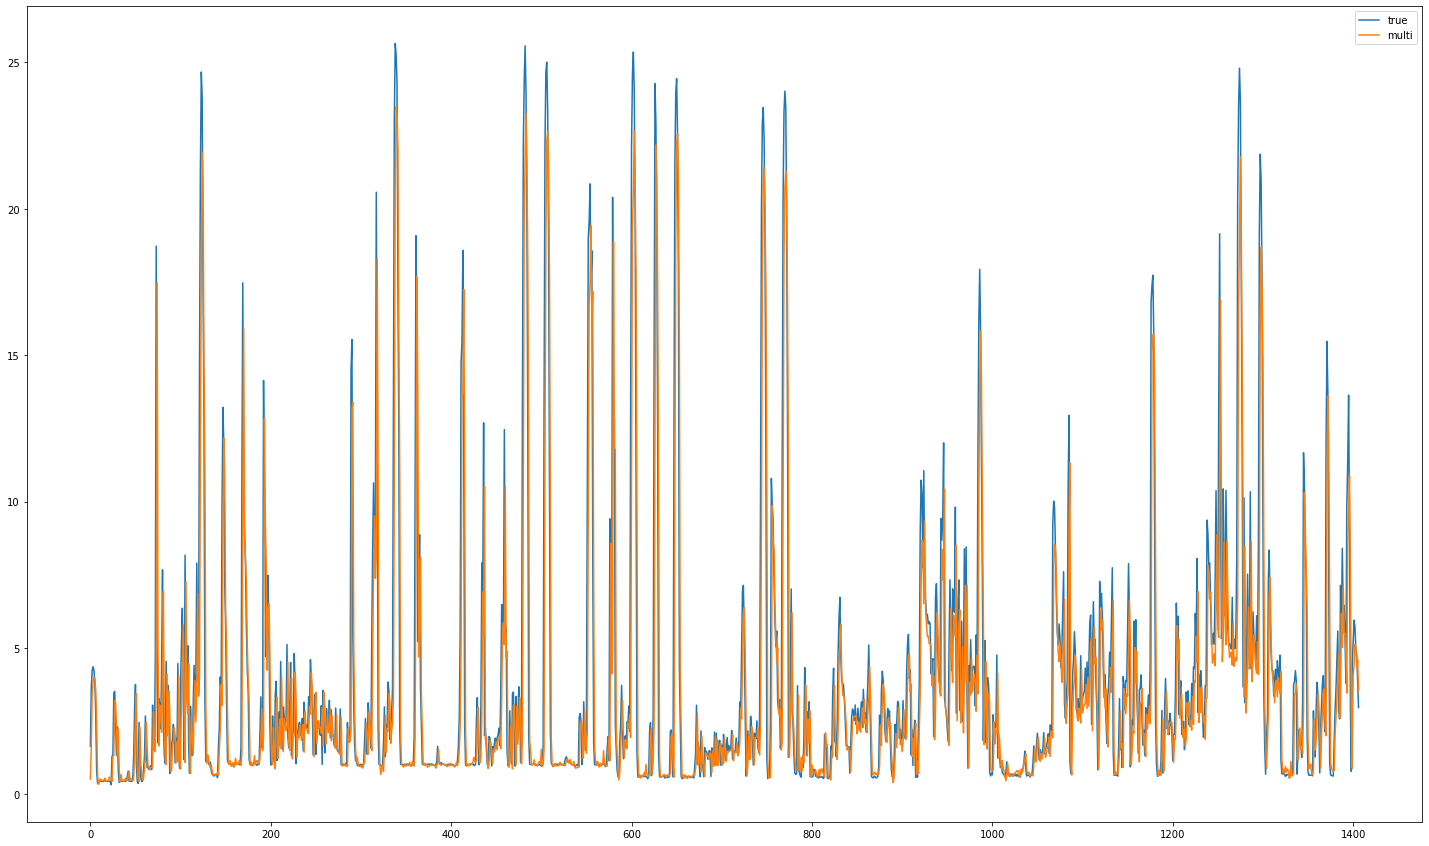

In [612]:
train_model(home_d, train_size=0.9, neurons=256, epochs=50, batch_size=64)

(23652, 1, 3) (23652,) (2628, 1, 3) (2628,)
Epoch 1/50
370/370 - 3s - loss: 0.0183 - mean_absolute_percentage_error: 1805.4248 - mean_absolute_error: 0.0183 - 3s/epoch - 8ms/step
Epoch 2/50
370/370 - 2s - loss: 0.0151 - mean_absolute_percentage_error: 1201.2299 - mean_absolute_error: 0.0151 - 2s/epoch - 5ms/step
Epoch 3/50
370/370 - 2s - loss: 0.0151 - mean_absolute_percentage_error: 1259.6908 - mean_absolute_error: 0.0151 - 2s/epoch - 4ms/step
Epoch 4/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1471.2474 - mean_absolute_error: 0.0149 - 2s/epoch - 5ms/step
Epoch 5/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1197.4452 - mean_absolute_error: 0.0149 - 2s/epoch - 5ms/step
Epoch 6/50
370/370 - 2s - loss: 0.0149 - mean_absolute_percentage_error: 1235.7390 - mean_absolute_error: 0.0149 - 2s/epoch - 7ms/step
Epoch 7/50
370/370 - 2s - loss: 0.0150 - mean_absolute_percentage_error: 1236.9332 - mean_absolute_error: 0.0150 - 2s/epoch - 6ms/step
Epoch 8/50


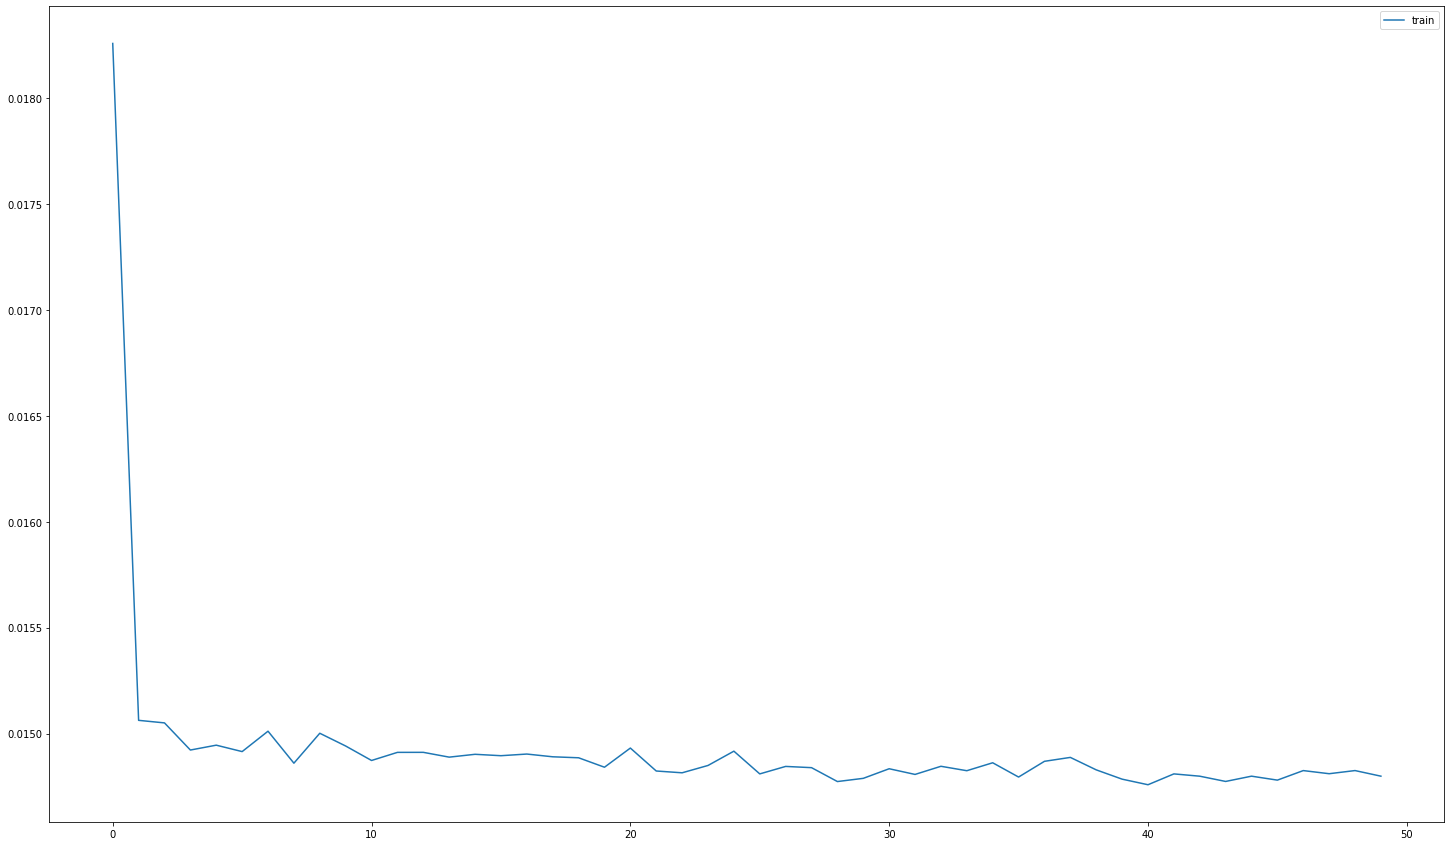

{'naive': 2.771548}


,true,multi
0,3.545602,3.541541
1,5.656806,3.541541
2,5.656806,5.690451
3,8.528798,5.690451
4,8.528798,8.592161
...,...,...
2623,6.889673,11.083158
2624,6.889673,6.936340
2625,3.975907,6.936340
2626,3.975907,3.993259


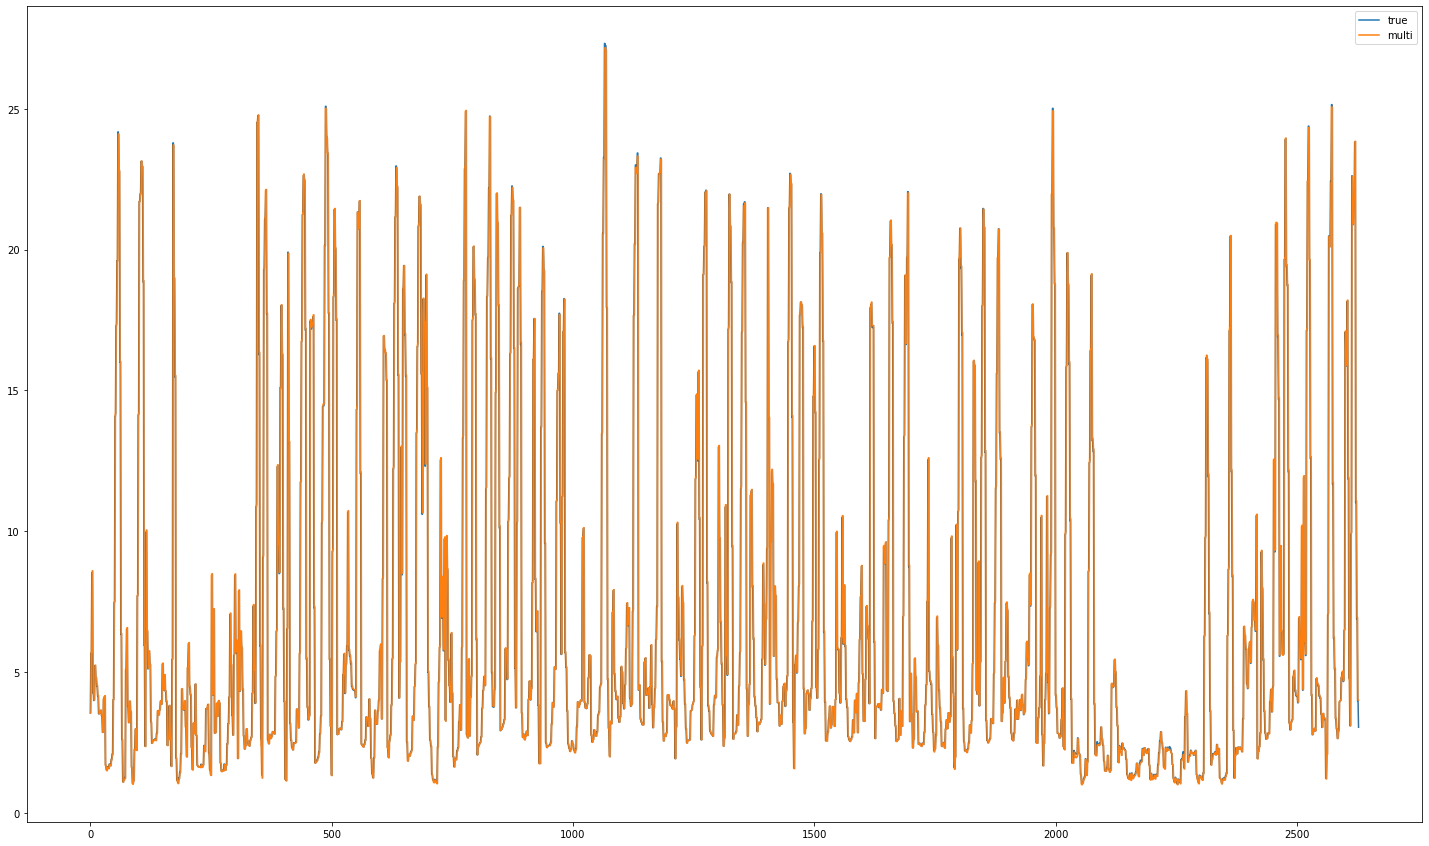

In [614]:
train_model(home_f)

# Federated approach

In [81]:
first=homes['total_a'].first_valid_index()
last= homes['total_a'].last_valid_index()


In [82]:
sub_home = homes.loc[first:last,:]

<AxesSubplot:ylabel='Date & Time'>

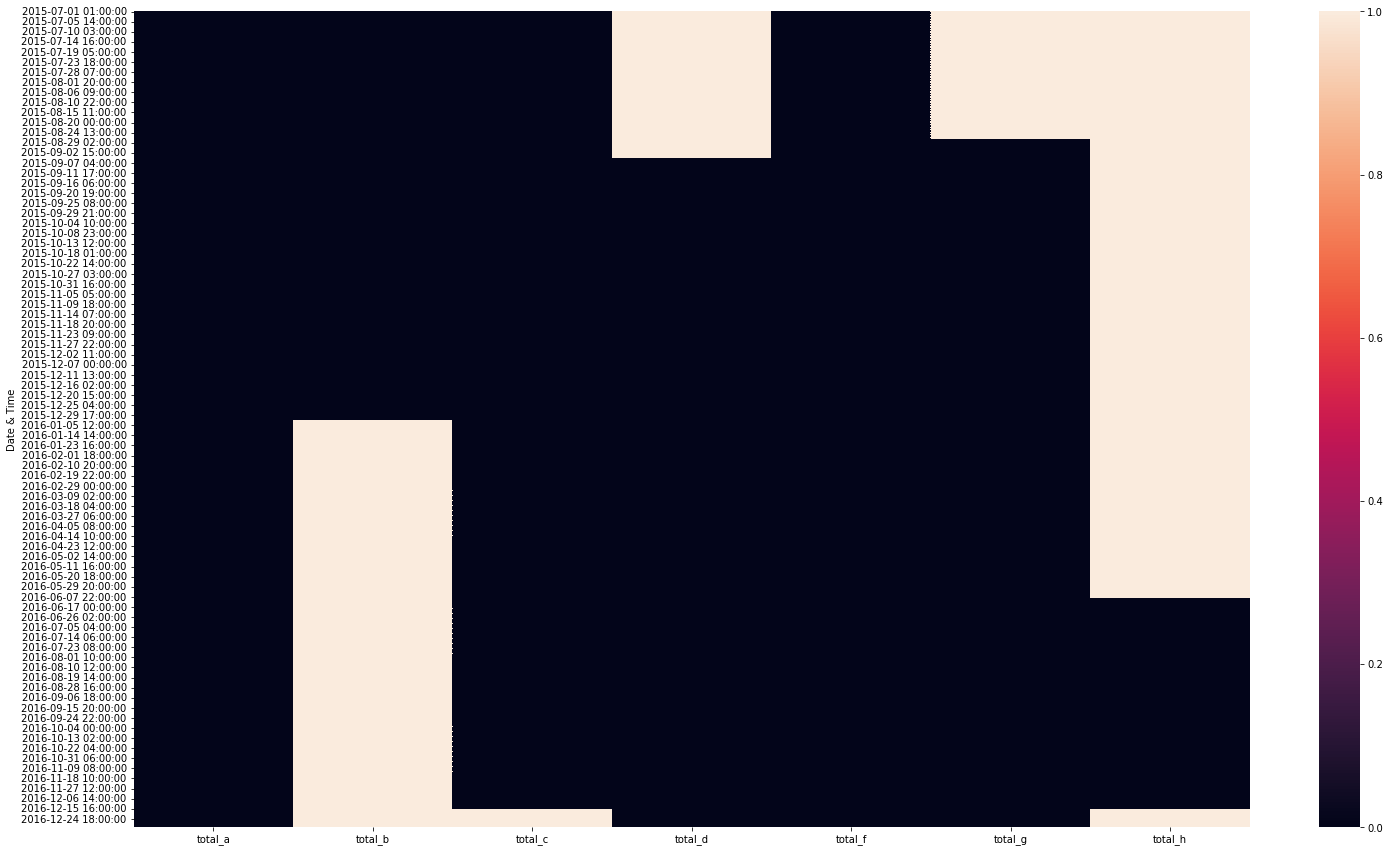

In [83]:
sns.heatmap(sub_home.isna())

In [84]:
a=len(sub_home['total_a'].dropna())
c= len(sub_home['total_c'].dropna())

b= len(sub_home['total_b'].dropna())
d = len(sub_home['total_d'].dropna())
f = len(sub_home['total_f'].dropna())
g = len(sub_home['total_g'].dropna())
h = len(sub_home['total_h'].dropna())


print(a, b,c, d,f,g,h)

17614 8830 17229 14446 17614 14846 4545


In [88]:
home_len=[a,b,c,d,f,g,h]
total_len = len(sub_home)

In [89]:
home_len

[17614, 8830, 17229, 14446, 17614, 14846, 4545]

In [90]:
for i in home_len:
    if i/total_len<0.8:
        print(" home %f is not viable"%i )

 home 8830.000000 is not viable
 home 4545.000000 is not viable


In [92]:
sub_home= sub_home.drop(['total_b', "total_h"],axis=1)

In [93]:
sub_home.dropna(inplace=True)

In [27]:
nonna =homes.notnull().sum()
nonna= nonna.values
nonna= nonna.tolist()
df_length= len(homes)
weights= [x/df_length for x in nonna]

In [95]:
def create_dataset(time_series, timesteps):
    dataX, dataY = [], []
    
    for i in range(0, len(time_series)-timesteps ): # The last 
        x = time_series[i:(i+timesteps)]    ####### Remember Python's x[a, b-1]
        dataX.append(x)
        y = time_series[(i+timesteps)]      ##### Remember Python's x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY) #dont forget to convert to np.arrays

In [101]:
energy= sub_home['total_a'].values
energy= energy.reshape(len(energy),1)
energy = energy.astype('float32')
print(energy.shape)


(14061, 1)


In [102]:
train, test = train_test_split(energy, train_size=0.8, shuffle=False)

In [103]:
# Scaling the data to the interval [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train)

train = scaler.transform(train)
test  = scaler.transform(test)

In [104]:
timesteps = 1 # parameter to tune, timesteps

# The LSTM input layer must be 3D
# Create the dataset with rolling window for the training set and test set
X_train, y_train  = create_dataset(train, timesteps)  # lookback
X_test, y_test    = create_dataset(test, timesteps)
X_train.shape

(11247, 1, 1)

### Vanilla LSTM

In [165]:
lstmmod = Sequential()
lstmmod.add(LSTM(256, return_sequences=True))
lstmmod.add(Dropout(0.2))
lstmmod.add(LSTM(256, return_sequences=False))
lstmmod.add(Dense(1))




In [166]:
lstmmod.compile(loss="mae", optimizer="adam", metrics=['mean_absolute_error'])

Epoch 1/50
156/156 - 4s - loss: 0.0493 - mean_absolute_error: 0.0493 - 4s/epoch - 26ms/step
Epoch 2/50
156/156 - 2s - loss: 0.0381 - mean_absolute_error: 0.0381 - 2s/epoch - 10ms/step
Epoch 3/50
156/156 - 2s - loss: 0.0378 - mean_absolute_error: 0.0378 - 2s/epoch - 10ms/step
Epoch 4/50
156/156 - 1s - loss: 0.0376 - mean_absolute_error: 0.0376 - 1s/epoch - 9ms/step
Epoch 5/50
156/156 - 2s - loss: 0.0375 - mean_absolute_error: 0.0375 - 2s/epoch - 10ms/step
Epoch 6/50
156/156 - 2s - loss: 0.0375 - mean_absolute_error: 0.0375 - 2s/epoch - 10ms/step
Epoch 7/50
156/156 - 1s - loss: 0.0378 - mean_absolute_error: 0.0378 - 1s/epoch - 9ms/step
Epoch 8/50
156/156 - 2s - loss: 0.0376 - mean_absolute_error: 0.0376 - 2s/epoch - 10ms/step
Epoch 9/50
156/156 - 2s - loss: 0.0374 - mean_absolute_error: 0.0374 - 2s/epoch - 10ms/step
Epoch 10/50
156/156 - 1s - loss: 0.0374 - mean_absolute_error: 0.0374 - 1s/epoch - 8ms/step
Epoch 11/50
156/156 - 2s - loss: 0.0373 - mean_absolute_error: 0.0373 - 2s/epoch -

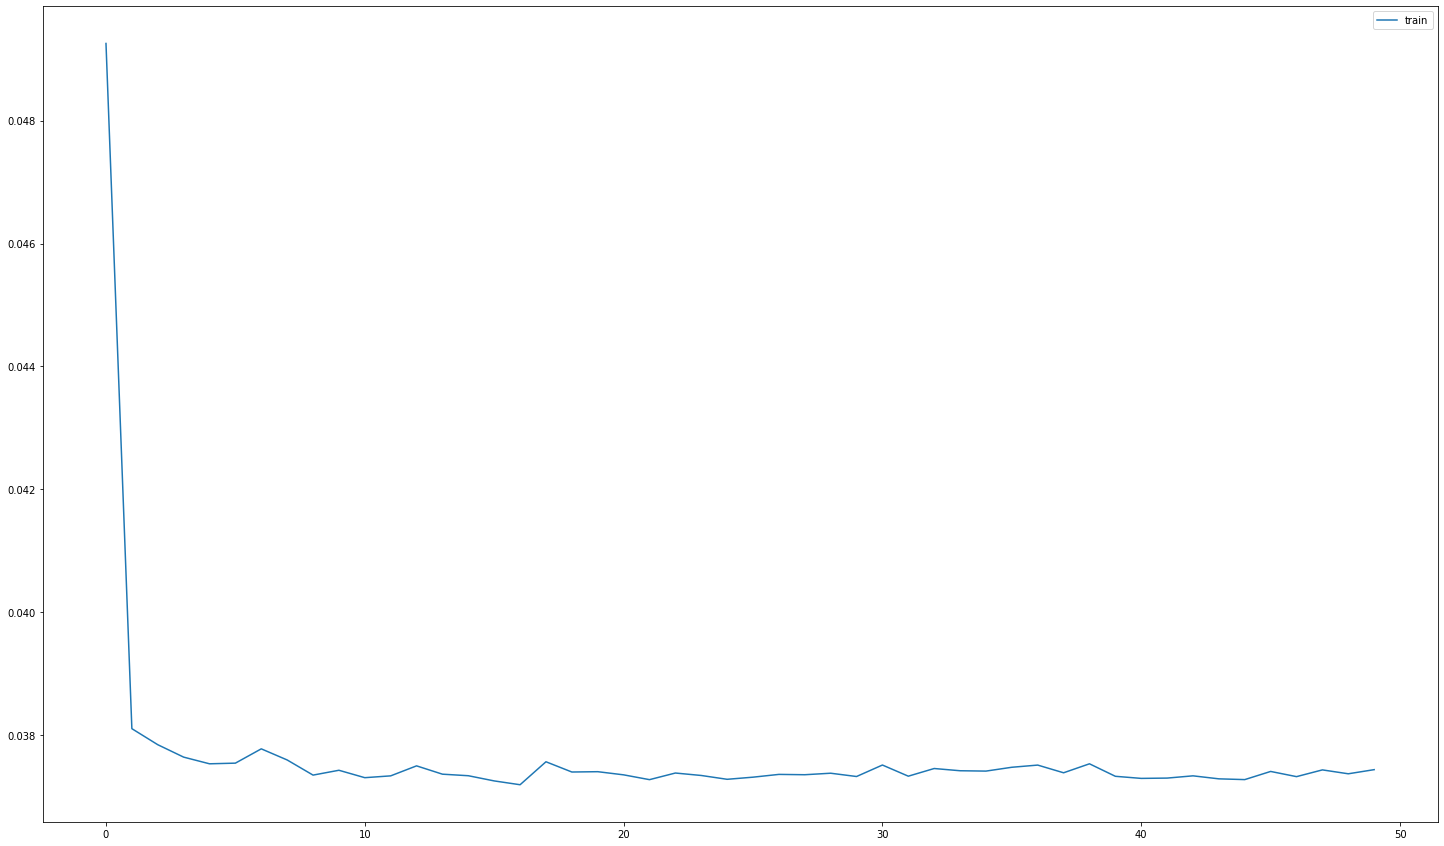

In [167]:
# fit network
history2 = lstmmod.fit(X_train, y_train,epochs=50, batch_size=72, verbose=2, shuffle=False)

# plot history
plt.plot(history2.history['loss'], label='train')
#plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()

# #Predict model
# yhat= model.predict(X_test)
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
# inv_yhat = np.concatenate((X_test, yhat), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat=inv_yhat[:,-1]
# #Invert scaling for actual 
# y_test = y_test.reshape(len(y_test),1)
# inv_y= np.concatenate((X_test, y_test), axis=1)
# inv_y = scaler.inverse_transform(inv_y)

# inv_y = inv_y[:,-1]

# def rmse(y_true, y_score):
#     error = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_score))
#     return error

# #pred_b_train= {}
# pred_b_test= {}

# pred_b_test['true'] = inv_y
# pred_b_test['multi'] = inv_yhat

# rmse_b_test["naive"]  = rmse(pred_b_test["true"],  pred_b_test["multi"])

# pred_b_test = pd.DataFrame(pred_b_test)
# print(rmse_b_test)

# pred_b_test.plot()

### Stateful LSTM

In [160]:
batch_size=72
time_steps=1

In [139]:
singlemod = Sequential()
singlemod.add(LSTM(256, stateful=True, batch_input_shape= (batch_size, time_steps, 1)))
singlemod.add(Dense(1))

singlemod.compile(loss="mae", optimizer= 'adam', metrics=['mean_absolute_error','mean_absolute_percentage_error'])


In [140]:
# The modulo % is the remainder after devision
rest = len(y_train) % batch_size
rest

0

In [141]:

X_train, y_train = X_train[rest:,:], y_train[rest:,:]

In [142]:
for i in range(20):
    singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=1,
          #validation_split=0.3, # We cannot afford validation data to be sampled automatically as this would break the data ordering 
          shuffle=False) # don't shuffle, we must keep the order of observations for the batches to match
    singlemod.reset_states()

156/156 [==============================] - 1s 8ms/step - loss: 0.0382 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 4137.8901


In [143]:
X_test_extended = np.vstack([X_train, X_test])

In [144]:
# Drop early observations to accomodate batch size
X_test_extended = X_test_extended[(X_test_extended.shape[0] % batch_size):,:]

In [145]:
# Performance evaluation is ALMOST as usual 
pred_train["stateful"] = scaler.inverse_transform(
                              singlemod.predict(X_train,verbose=0, batch_size=batch_size)
).flatten()

# However, there is one important bit
singlemod.reset_states()

In [146]:
pred_test={}

In [147]:
pred_test_extended = singlemod.predict(X_test_extended, verbose=0, batch_size=batch_size)

pred_test["stateful"] = scaler.inverse_transform(
                              pred_test_extended[-len(y_test):]
).flatten()

# Collect the hidden states before resetting them
state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
state_before_reset
#stateful.reset_states()

/var/folders/nm/jvmw76_11mbgvd6lxfqd3cg00000gq/T/ipykernel_76205/4088356753.py:8: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_before_reset = [keras.backend.get_value(s) for s, _ in singlemod.state_updates]
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2721: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  if hasattr(layer, 'updates'):
/Users/daniel.bustillo/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/keras/engine/training.py:2722: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  state_updates += layer.updates


[]

In [148]:
pred_test_extended[-len(y_test):]

array([[0.07485981],
       [0.0496344 ],
       [0.05365141],
       ...,
       [0.10153005],
       [0.0964364 ],
       [0.10964121]], dtype=float32)

In [149]:
singlemod.fit(X_train, y_train, batch_size=batch_size, epochs=20)

Epoch 1/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0381 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 3875.7832
Epoch 2/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3477.1311
Epoch 3/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3846.0767
Epoch 4/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3426.2812
Epoch 5/20
156/156 [==============================] - 1s 6ms/step - loss: 0.0378 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 3725.6306
Epoch 6/20
156/156 [==============================] - 1s 7ms/step - loss: 0.0377 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 3826.3826
Epoch 7/20
156/156 [==============================] - 1s 6ms/step - lo

In [150]:
len(pred_test['stateful'])

2812

In [151]:
pred_test['true']= np.array(y_test).reshape(y_test.shape[0])

In [152]:
pred_test['stateful'].shape
pred_test['true'].shape


(2812,)

<AxesSubplot:>

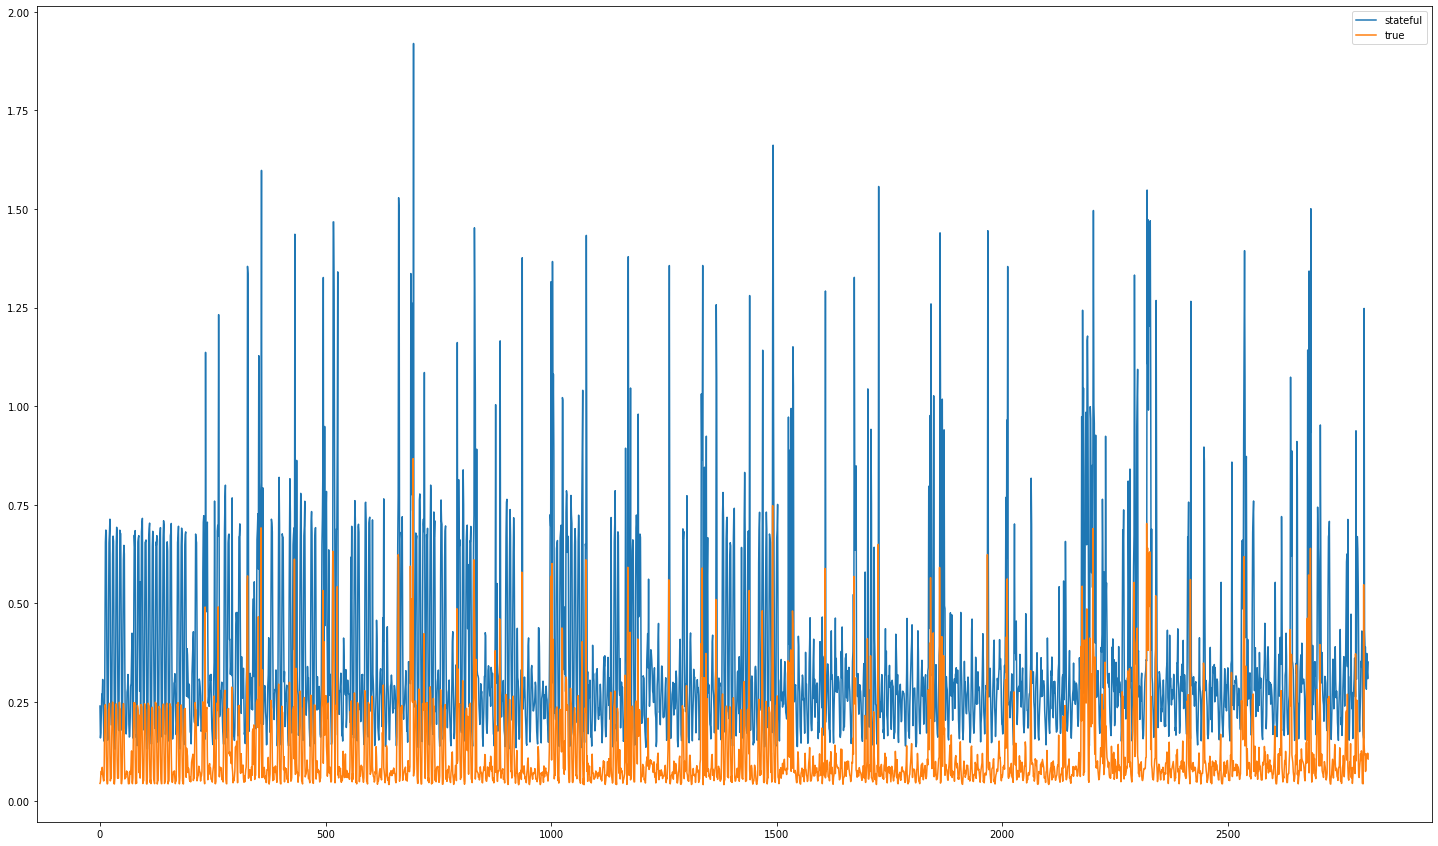

In [153]:
pd.DataFrame(pred_test).plot()

In [568]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [569]:
modell = LSTMmodel()

global_model = modell.build(256, 0.2)

In [570]:
global_model.compile(loss="mean_squared_error", optimizer="adam")

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    random.shuffle(client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(784, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10) 

SGD_model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=metrics)

# fit the SGD training data to model
_ = SGD_model.fit(SGD_dataset, epochs=100, verbose=0)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

In [630]:
# multivariate cnn example

from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = [],[]
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[207.06941]]
